# Assignment 1 - Code Example - Part A

This code baseline is inspired by and modified from [this great tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

This code can achieve an accuracy of approximately 86.50% on CIFAR-10. Please set up the environment and run your experiments starting from this baseline. You are expected to achieve an accuracy higher than this baseline.

In [1]:
# import some necessary packages
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as tv_datasets
import torchvision
import torchvision.transforms as tv_transforms
import matplotlib.pyplot as plt

In [2]:
# some experimental setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 100
batch_size = 64
num_workers = 6
print_every = 200

optim_name = "Adam"
optim_kwargs = dict(
    lr=3e-4,
    weight_decay=1e-6,
)

# early stopping settings
# patience = 20
# best_val_loss = float("inf")
# no_improve_count = 0

# preprocessing pipeline for input images
transformation = dict()
for data_type in ("train", "test"):
    is_train = data_type=="train"
    transformation[data_type] = tv_transforms.Compose(([
        tv_transforms.RandomRotation(degrees=15),
        tv_transforms.RandomHorizontalFlip(),
        tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    ] if is_train else []) + 
    [
        tv_transforms.ToTensor(),
        tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

In [ ]:
# prepare datasets
dataset, loader = {}, {}
for data_type in ("train", "test"):
    is_train = data_type=="train"
    dataset[data_type] = tv_datasets.CIFAR10(
        root="./data", train=is_train, download=True, transform=transformation[data_type],
    )
    loader[data_type] = torch.utils.data.DataLoader(
        dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
    )

# data split for early stopping strategy

# dataset, loader = {}, {}
# train_dataset = tv_datasets.CIFAR10(
#     root="./data", train=True, download=True, transform=transformation["train"],
# )

# # train, val split
# train_size = int(0.8 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# dataset["train"], dataset["val"] = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# # test set
# dataset["test"] = tv_datasets.CIFAR10(
#     root="./data", train=False, download=True, transform=transformation["test"],
# )

# # dataloader
# loader["train"] = torch.utils.data.DataLoader(
#     dataset["train"], batch_size=batch_size, shuffle=True, num_workers=num_workers,
# )
# loader["val"] = torch.utils.data.DataLoader(
#     dataset["val"], batch_size=batch_size, shuffle=False, num_workers=num_workers,
# )
# loader["test"] = torch.utils.data.DataLoader(
#     dataset["test"], batch_size=batch_size, shuffle=False, num_workers=num_workers,   
# )

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# our network architecture
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        # Whether to downsample the input
        self.downsample = downsample
        # Stride for convolution operations
        stride = 2 if downsample else 1

        # First convolution layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        # First batch normalization layer
        self.bn1 = nn.BatchNorm2d(out_channels)
        # ReLU activation
        self.relu = nn.ReLU(inplace=True)
        # Second convolution layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        # Second batch normalization layer
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection
        if downsample or in_channels != out_channels:
            # If downsampling or channel mismatch, use a 1x1 convolution
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            # Otherwise, use identity mapping
            self.shortcut = nn.Identity()

    def forward(self, x):
        # Apply shortcut connection
        shortcut = self.shortcut(x)
        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # Add shortcut to main path
        out += shortcut
        out = self.relu(out)
        return out


class ResNetCIFAR10(nn.Module):
    def __init__(self):
        super(ResNetCIFAR10, self).__init__()
        # Number of input channels for the first layer
        self.in_channels = 64
        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # Batch normalization layer
        self.bn1 = nn.BatchNorm2d(64)
        # ReLU activation
        self.relu = nn.ReLU(inplace=True)
        # Three residual layers with increasing channels
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, downsample=True)
        self.layer3 = self._make_layer(256, 2, downsample=True)
        # Adaptive average pooling to reduce spatial dimensions to 1x1
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer for classification
        self.fc = nn.Linear(256, 10)

    def _make_layer(self, out_channels, num_blocks, downsample=False):
        # Create a layer with multiple residual blocks
        layers = []
        # First block may downsample
        layers.append(ResidualBlock(self.in_channels, out_channels, downsample))
        self.in_channels = out_channels
        # Add remaining blocks
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the network
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# initialize model
net = ResNetCIFAR10().to(device)

# print the number of parameters
print(f"number of parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad) / 1_000_000:.2f}M")

number of parameters: 2.78M


In [5]:
# validate function designed for early stopping startegy
def validate(model, val_loader, criterion,  device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for img, target in val_loader:
            img, target = img.to(device), target.to(device)
            pred = model(img)
            val_loss += criterion(pred, target).item()

    return val_loss / len(val_loader)

## Start Training

### early stop version

In [6]:
# # the network optimizer
# optimizer = getattr(optim, optim_name)(net.parameters(), **optim_kwargs)

# # loss function
# criterion = nn.CrossEntropyLoss()

# # training loop
# net.train()
# for epoch in range(num_epochs):

#     running_loss = 0.0
#     for i, (img, target) in enumerate(loader["train"]):
#         img, target = img.to(device), target.to(device)

#         pred = net(img)
#         loss = criterion(pred, target)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % print_every == print_every - 1:
#             print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] loss: {running_loss / print_every:.3f}")
#             running_loss = 0.0
    
#     # validation loop using early stopping
#     val_loss = validate(net, loader["val"], criterion, device)

#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         no_improve_count = 0
#         # save best model
#         torch.save(net.state_dict(), "best_model.pth")
#         print("Saved best model")
#     else:
#         no_improve_count += 1
    
#     # print validation loss
#     print(f"Validation loss: {val_loss:.3f}")
    
#     # early stopping
#     if no_improve_count >= patience:
#         print("Early stopping")
#         break

# print("Finished Training")

### no early stop version

In [7]:
# the network optimizer
optimizer = getattr(optim, optim_name)(net.parameters(), **optim_kwargs)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)

# loss function
criterion = nn.CrossEntropyLoss()

train_loss_cifar10 = []

# training loop
net.train()
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, (img, target) in enumerate(loader["train"]):
        img, target = img.to(device), target.to(device)

        pred = net(img)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == print_every - 1:
            print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] loss: {running_loss / print_every:.3f}")
            running_loss = 0.0
    train_loss_cifar10.append(running_loss / len(loader["train"]))
    scheduler.step()
    
print("Finished Training")

[epoch=  1, iter=  200] loss: 1.677
[epoch=  1, iter=  400] loss: 1.381
[epoch=  1, iter=  600] loss: 1.186
[epoch=  2, iter=  200] loss: 1.007
[epoch=  2, iter=  400] loss: 0.942
[epoch=  2, iter=  600] loss: 0.914
[epoch=  3, iter=  200] loss: 0.794
[epoch=  3, iter=  400] loss: 0.781
[epoch=  3, iter=  600] loss: 0.747
[epoch=  4, iter=  200] loss: 0.670
[epoch=  4, iter=  400] loss: 0.666
[epoch=  4, iter=  600] loss: 0.661
[epoch=  5, iter=  200] loss: 0.596
[epoch=  5, iter=  400] loss: 0.590
[epoch=  5, iter=  600] loss: 0.589
[epoch=  6, iter=  200] loss: 0.538
[epoch=  6, iter=  400] loss: 0.541
[epoch=  6, iter=  600] loss: 0.537
[epoch=  7, iter=  200] loss: 0.492
[epoch=  7, iter=  400] loss: 0.499
[epoch=  7, iter=  600] loss: 0.491
[epoch=  8, iter=  200] loss: 0.463
[epoch=  8, iter=  400] loss: 0.459
[epoch=  8, iter=  600] loss: 0.469
[epoch=  9, iter=  200] loss: 0.436
[epoch=  9, iter=  400] loss: 0.440
[epoch=  9, iter=  600] loss: 0.426
[epoch= 10, iter=  200] loss

## Evaluating its accuracy

In [8]:
net.eval()
correct, total = 0, 0
with torch.no_grad():
    for img, target in loader["test"]:
        img, target = img.to(device), target.to(device)
        
        # make prediction
        pred = net(img)
        
        # accumulate
        total += len(target)
        correct += (torch.argmax(pred, dim=1) == target).sum().item()

print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")

Accuracy of the network on the 10000 test images: 93.07%


## visualization for training_loss_cifar10

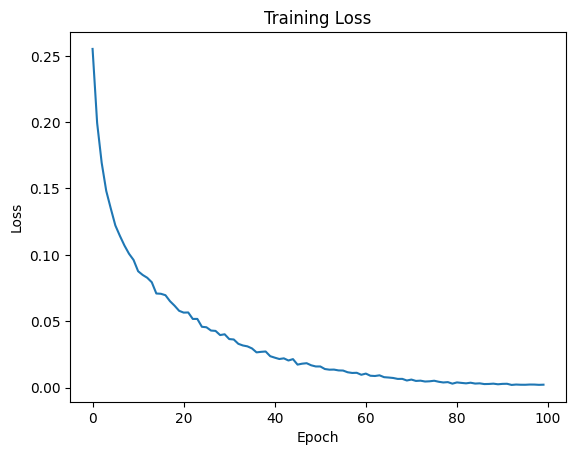

In [9]:
plt.plot(train_loss_cifar10)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Mnist

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 30
batch_size = 64
num_workers = 6
print_every = 200

optim_name = "Adam"
optim_kwargs = dict(
    lr=3e-4,
    weight_decay=1e-6,
)

transformation = dict()
for data_type in ("train", "test"):
    is_train = data_type=="train"
    transformation[data_type] = tv_transforms.Compose(([
        tv_transforms.RandomRotation(degrees=15),
        # remove RandomHorizontalFlip (number horizontal flip will change meaning)
        tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    ] if is_train else []) + 
    [
        tv_transforms.Resize(28),  # MNIST size is 28*28
        tv_transforms.ToTensor(),
        tv_transforms.Normalize(mean=[0.5], std=[0.5]),  # single channel
    ])

In [11]:
# prepare datasets
dataset, loader = {}, {}
for data_type in ("train", "test"):
    is_train = data_type=="train"
    dataset[data_type] = tv_datasets.MNIST( 
        root="./data", train=is_train, download=True, transform=transformation[data_type],
    )
    loader[data_type] = torch.utils.data.DataLoader(
        dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
    )

In [12]:
# ResNet model
class ResNetMNIST(nn.Module):
    def __init__(self):
        super(ResNetMNIST, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, downsample=True)
        self.layer3 = self._make_layer(256, 2, downsample=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 10)
    def _make_layer(self, out_channels, num_blocks, downsample=False):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, downsample))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# initialize model
net = ResNetMNIST().to(device)

# print the number of parameters
print(f"number of parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad) / 1_000_000:.2f}M")

number of parameters: 2.78M


In [13]:
# the network optimizer
optimizer = getattr(optim, optim_name)(net.parameters(), **optim_kwargs)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)

# loss function
criterion = nn.CrossEntropyLoss()

train_loss_mnist = []

# training loop
net.train()
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, (img, target) in enumerate(loader["train"]):
        img, target = img.to(device), target.to(device)

        pred = net(img)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == print_every - 1:
            print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] loss: {running_loss / print_every:.3f}")
            running_loss = 0.0

    train_loss_mnist.append(running_loss)
    scheduler.step()

print("Finished Training")

[epoch=  1, iter=  200] loss: 0.358
[epoch=  1, iter=  400] loss: 0.105
[epoch=  1, iter=  600] loss: 0.084
[epoch=  1, iter=  800] loss: 0.070
[epoch=  2, iter=  200] loss: 0.053
[epoch=  2, iter=  400] loss: 0.056
[epoch=  2, iter=  600] loss: 0.053
[epoch=  2, iter=  800] loss: 0.049
[epoch=  3, iter=  200] loss: 0.045
[epoch=  3, iter=  400] loss: 0.042
[epoch=  3, iter=  600] loss: 0.043
[epoch=  3, iter=  800] loss: 0.045
[epoch=  4, iter=  200] loss: 0.038
[epoch=  4, iter=  400] loss: 0.036
[epoch=  4, iter=  600] loss: 0.035
[epoch=  4, iter=  800] loss: 0.037
[epoch=  5, iter=  200] loss: 0.034
[epoch=  5, iter=  400] loss: 0.037
[epoch=  5, iter=  600] loss: 0.036
[epoch=  5, iter=  800] loss: 0.031
[epoch=  6, iter=  200] loss: 0.029
[epoch=  6, iter=  400] loss: 0.027
[epoch=  6, iter=  600] loss: 0.032
[epoch=  6, iter=  800] loss: 0.028
[epoch=  7, iter=  200] loss: 0.035
[epoch=  7, iter=  400] loss: 0.027
[epoch=  7, iter=  600] loss: 0.029
[epoch=  7, iter=  800] loss

In [14]:
net.eval()
correct, total = 0, 0
with torch.no_grad():
    for img, target in loader["test"]:
        img, target = img.to(device), target.to(device)
        
        # make prediction
        pred = net(img)
        
        # accumulate
        total += len(target)
        correct += (torch.argmax(pred, dim=1) == target).sum().item()

print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")

Accuracy of the network on the 10000 test images: 99.65%


## visualization for training_loss_mnist

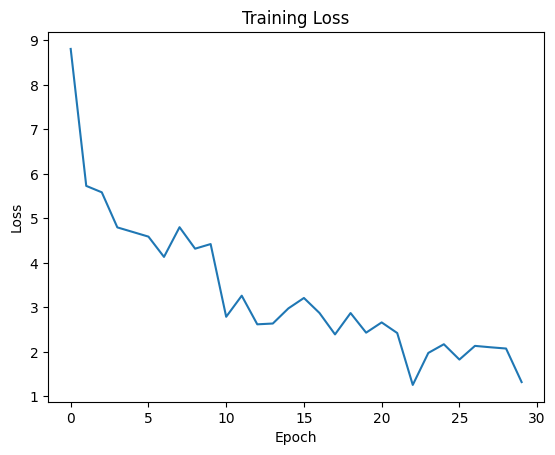

In [15]:
plt.plot(train_loss_mnist)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()